# Machine Learning with Numerical Methods: Used Car Sales

## Project Description
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [52]:
# Start by importing all the necessary libraries and packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import time

In [53]:
# Create a new dataframe with the dataset then look at the data
cars = pd.read_csv('/datasets/car_data.csv')

In [54]:
cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [55]:
# Let's convert all column names to snake case
print(cars.columns)
cars.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower().replace(' ', '_') for col in cars.columns]
print(cars.columns)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')
Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')


In [56]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

<span style = 'color:blue'> Comments: After I checked the data, I saw there are 354,369 entries and 16 columns, making this a big dataset. I also saw that many of the columns have a good amount of null values. As such, my first tasks were to check for null values, eliminate duplicates and analyze what to do with the null values.

In [57]:
is_null = cars.isnull().sum().reset_index()
is_null_percent = (cars.isnull().mean()*100).round(2).reset_index()
cars_null = is_null.merge(is_null_percent, on ='index')
cars_null = cars_null.rename(columns = {'index':'column_name', '0_x':'total_na', '0_y':'percent_na'})
cars_null

,column_name,total_na,percent_na
0,date_crawled,0,0.00
1,price,0,0.00
2,vehicle_type,37490,10.58
3,registration_year,0,0.00
4,gearbox,19833,5.60
5,power,0,0.00
6,model,19705,5.56
7,mileage,0,0.00
8,registration_month,0,0.00
9,fuel_type,32895,9.28


In [58]:
# Check for duplicated entries
duplicates = cars.duplicated().sum()
print(f'There are {duplicates} many duplicate entries')

# Drop duplicated entries
cars = cars.drop_duplicates()
print(f'All duplicate rows are dropped. There are {cars.duplicated().sum()} duplicates left')

There are 262 many duplicate entries
All duplicate rows are dropped. There are 0 duplicates left


In [59]:
# Handling the Missing values
cars['vehicle_type'] = cars['vehicle_type'].fillna('unknown')
cars['gearbox'] = cars['gearbox'].fillna('unknown')
cars['model'] = cars['model'].fillna('unknown')
cars['fuel_type'] = cars['fuel_type'].fillna('unknown')
cars['not_repaired'] = cars['not_repaired'].fillna('unknown')

# Updates made to the following:
#cars['gearbox'] = cars['gearbox'].fillna(cars['gearbox'].mode()[0])
#cars['fuel_type'] = cars['fuel_type'].fillna(cars['fuel_type'].mode()[0])

In [60]:
# Verify Null Values are handled
cars.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

<span style='color:blue'> Comments: To handle missing values, I approached each column separately. Since there are a lot of missing values, we cannot simply remove them.
- Vehicle type has ~10% missing data, so creata new category called 'unknown'
- Gearbox has ~5% missing data but only 2 options (manual or auto), safe to fill in with Mode
- Model has ~5% missing data but is an important feature, so create an unknown category
- Fuel Type has ~10% missing data and a few options but I chose to fill in with Mode
- Not Repaired has ~20% missing data so let's be safe and create an unknown category

In [61]:
# Check how many cars have $0 price
print((cars['price']==0).value_counts())
cars = cars[cars['price'] != 0]
print()
print((cars['price']==0).value_counts())

False    343337
True      10770
Name: price, dtype: int64

False    343337
Name: price, dtype: int64


<span style = color:blue> comments: There are over 10,000 entries with car price = 0. This doesn't make sense since Rusty Bargain is trying to sell the cars at a profit, not give them out for free. This must be a mistake and it will only skew the data when we start modeling. Given that Price is the Target, it is a good idea to drop all entries with price = 0.

In [62]:
# The HP of many of these cars is completely unrealistic, let's eliminate this lot
cars = cars[(cars['power'] < 253) & (cars['power'] > 50)]
cars.shape

(289618, 16)

<span style = 'color: blue'>  Comments: I noticed there were many vehicles with over 500HP, many were even going up to 20,000HP. This is not normal or realistic, since the average consumer vehicles range between 150-250HP, and some larger vehicles can go above 300 as well. I chose to play it safe and remove all entries with HP greater than 400HP as that is more than sufficient, since we are not working with supercars or custom-designed cars. Additionally, I also noticed there were over 36,000 vehicles with a 0 HP. This is unusual as that means the engines are not funcitioning. I would love to remove these entries as well but since these are used vehicles, it is possible that vehicles with non-working engines are also on the market. We don't have enough data to justify removing these entires yet.

In [63]:
# There is something odd about the registration year, let's take a closer look
print(sorted(cars['registration_year'].unique()))

[1000, 1500, 1910, 1937, 1941, 1942, 1943, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2800, 2900, 4500, 5000, 5911, 6000, 6500, 8000, 8200, 9999]


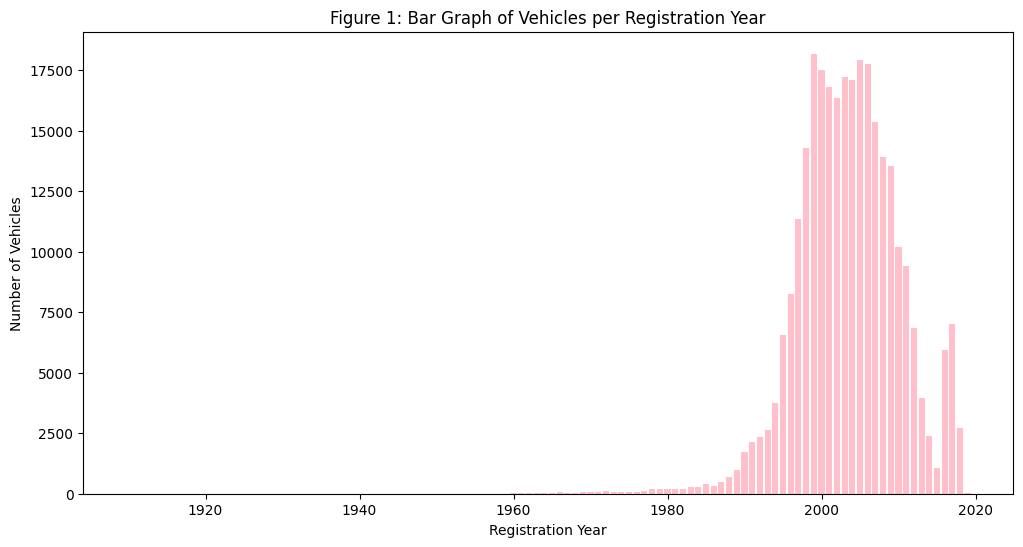

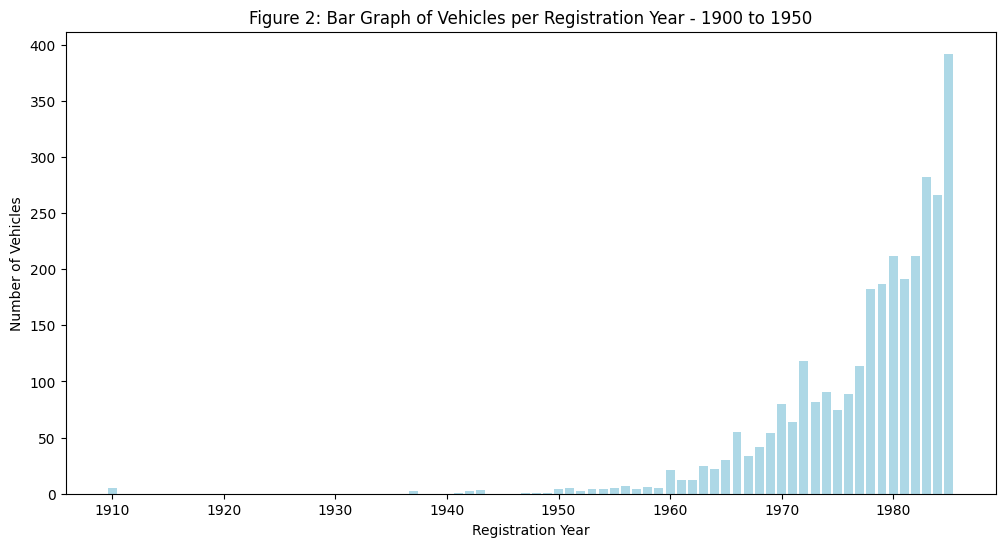

In [64]:
# We should remove all entries with an inaccurate year
cars = cars[(cars['registration_year'] > 1800) & (cars['registration_year'] < 2026)]
cars_old = cars[(cars['registration_year'] > 1900) & (cars['registration_year'] < 1986)]

cars_years_sorted = cars['registration_year'].value_counts()
cars_old_sorted = cars_old['registration_year'].value_counts()

plt.figure(figsize=(12,6))
plt.bar(cars_years_sorted.index, cars_years_sorted.values, color = 'pink')
plt.title("Figure 1: Bar Graph of Vehicles per Registration Year")
plt.xlabel('Registration Year')
plt.ylabel('Number of Vehicles')
plt.show()

plt.figure(figsize=(12,6))
plt.bar(cars_old_sorted.index, cars_old_sorted.values, color = 'lightblue')
plt.title("Figure 2: Bar Graph of Vehicles per Registration Year - 1900 to 1950")
plt.xlabel('Registration Year')
plt.ylabel('Number of Vehicles')
plt.show()

In [65]:
cars = cars[(cars['registration_year'] > 1985) & (cars['registration_year'] < 2026)]
print(sorted(cars['registration_year'].unique()))
print()
print(f"Total Entries in Car database now = {cars.shape}")

[1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

Total Entries in Car database now = (286592, 16)


<span style = 'color:blue'> Comments: A quick check for the unique values for the registration year shows a wide range of values that are just not possible. This means there are incorrect values that should be removed otherwise we will skew the data. I removed the entries before 1900s and after 2026. Next, graphing the count of vehicles per year gives a good idea of whether the entries between 1900 and 1985 are legitamate or meaningful. Based on the graphical representations, I decided it was fair to eliminate entries prior to 1985, using a generous 40 year period of car shelf life.

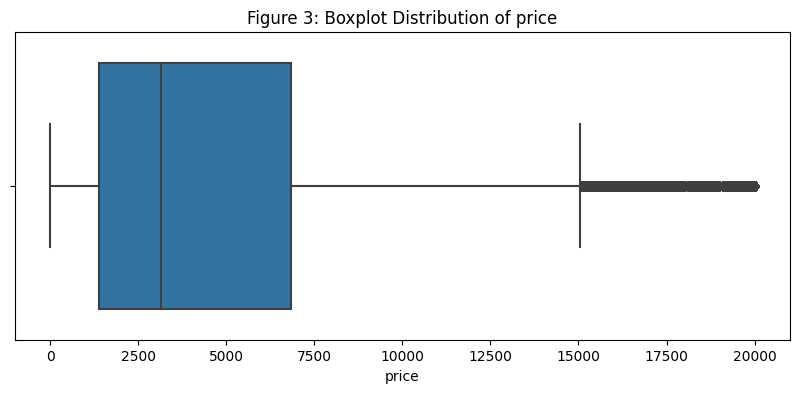

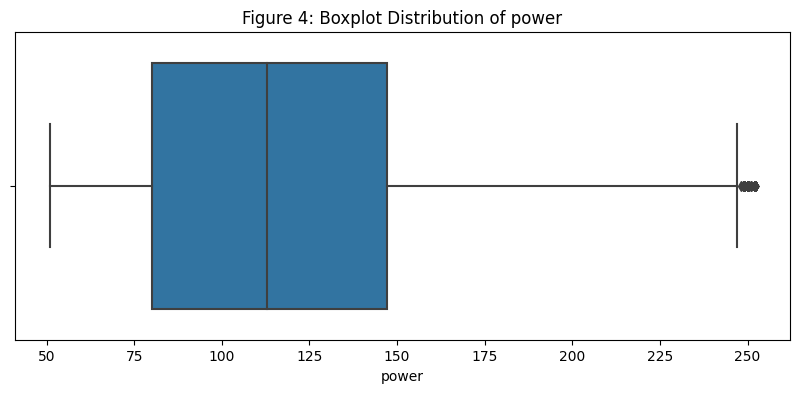

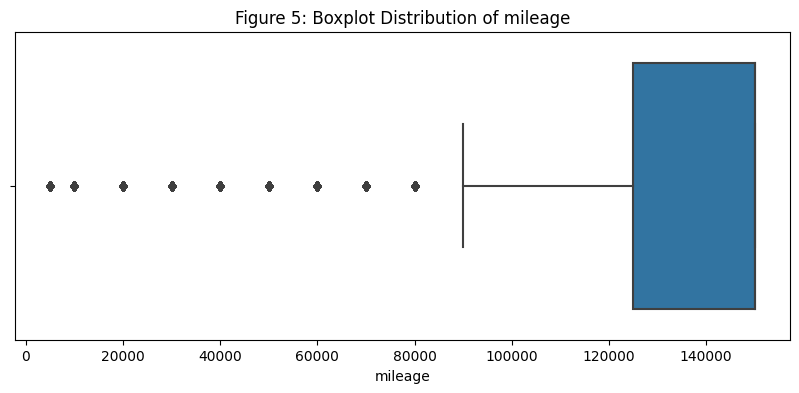

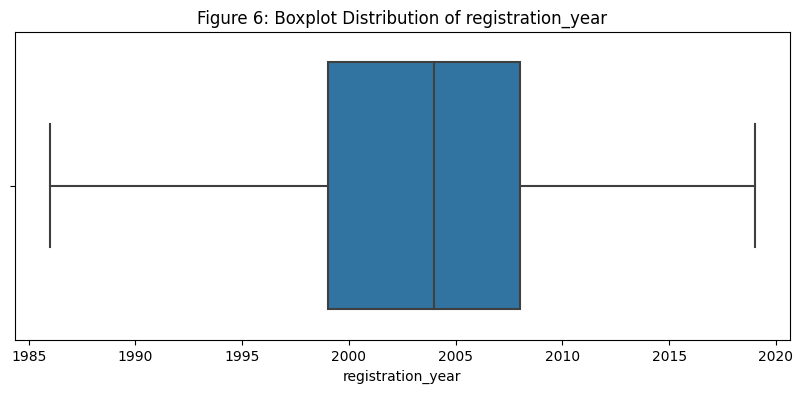

In [66]:
# Show some graphical representations, outliers?
features_num = ['price', 'power', 'mileage','registration_year']
k = 3
for i in features_num:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=cars[i])
    plt.title(f'Figure {k}: Boxplot Distribution of {i}')
    k += 1
    plt.show()

<span style='color:blue'>

<span style ='color:blue'> Comments: I graphed the distributions using boxplots for a few of the key features to understand how the data was looking. I did notice many outliers and went back above to eliminate them such as entries with price = 0, HP > 500 and years out of realistic ranges. After doing that, I re-ran the graphs to their current state and there are still many outliers but there is no need to remove them. I think this was enough EDA and chose to move on to the model training portion.

<span style = color:blue> Comments: There are many outliers especially within the price column, I chose to leave them in there on the basis of maybe there was some credibility to those prices. However, I am more than comfortable removing those entries from the dataset. I updated my code below where I called the describe method, then I calculated the upper and lower bounds of price and removed all entries greater than the upper bound. I did the same for the mileage and power columns. However, for power, I just went back up to where I originally narrowed down the power to 400 and changed it to 252, as per the upper bound I calculated below.

<span style = color:blue> Comments: Petrol and gasoline refer to the same fuel, so we can use one of these categories. There are also some rare model categories that can be dropped. If a category appears only in the training or validation subset, for instance, and we use `handle_unknown='ignore'`, the linear model might miss important signals in validation or make predictions with incomplete features thus breaking the assumptions of linearity. It may be helpful to make sure that training and validation subsets use the same feature columns after encoding. 


In [67]:
cars.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,286592.000000,286592.000000,286592.000000,286592.000000,286592.000000,286592.0,286592.000000
mean,4748.805790,2003.783375,118.528647,128698.079500,5.982002,0.0,51259.185120
std,4471.493985,6.129833,44.389637,36446.802937,3.595379,0.0,25769.449244
min,1.000000,1986.000000,51.000000,5000.000000,0.000000,0.0,1067.000000
25%,1380.000000,1999.000000,80.000000,125000.000000,3.000000,0.0,30974.000000
50%,3149.000000,2004.000000,113.000000,150000.000000,6.000000,0.0,50259.000000
75%,6850.000000,2008.000000,147.000000,150000.000000,9.000000,0.0,72074.000000
max,20000.000000,2019.000000,252.000000,150000.000000,12.000000,0.0,99998.000000


In [68]:
# Calculate the outliers in price and mileage column
price_IQR = 6850 - 1380
price_lower = 1380 - 1.5 * price_IQR
price_upper = 6850 + 1.5 * price_IQR
print(price_lower,'and', price_upper)

mileage_IQR = 150000 - 125000
mileage_lower = 125000 - 1.5 * mileage_IQR
mileage_upper = 150000 + 1.5 * mileage_IQR
print(mileage_lower, 'and', mileage_upper)

power_IQR = 150 - 82
lower_power = 82 - 1.5 * power_IQR
upper_power = 150 + 1.5 * power_IQR
print(lower_power, 'and', upper_power)

# Let's remove all outliers in the Price and Mileage columns
cars = cars[(cars['price'] < 16000) & (cars['price'] > 100)]
cars = cars[(cars['mileage'] >= 87500)]
cars.shape

-6825.0 and 15055.0
87500.0 and 187500.0
-20.0 and 252.0


(238302, 16)

<span style=color:blue> Comments: QR may not be very helpful if the distribution is not normal. Not everything outside the boxplot whiskers is outlier. Likewise, not everything within whiskers is a normal data. This is because the whisker goes either to the maximum (minimum) or to 1.5 times the length of the box. The concentration of circles on the boxplot above or below the whiskers can be very high. Cutting off the whiskers, we can sometimes lose important information, as our sample can be really biased.

## Model training

In [70]:
cars.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [71]:
# Let's first drop unnecessary columns then check for duplicates
cars_new = cars.drop(columns=['date_crawled', 'date_created', 'last_seen'])
print(f'\nCheck for duplicates: {cars_new.duplicated().sum()}')
cars_new[cars_new.duplicated()].head(3)


Check for duplicates: 14529


,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,number_of_pictures,postal_code
3551,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no,0,52388
3786,2999,sedan,2002,manual,101,golf,150000,6,gasoline,volkswagen,no,0,32756
3907,500,small,1999,manual,55,corsa,150000,12,petrol,opel,no,0,51377


In [72]:
# Verify that these are indeed duplicates
cars[(cars['price'] == 1670) & (cars['model'] == 'golf')]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
824,11/03/2016 12:54,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no,11/03/2016 00:00,0,52388,23/03/2016 03:19
3551,22/03/2016 21:55,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no,22/03/2016 00:00,0,52388,22/03/2016 21:55


In [73]:
# Once duplicates are verified, delete duplicates and double check

cars_new.drop_duplicates(inplace=True)
print(f'\nCheck for duplicates: {cars_new.duplicated().sum()}')

# Now, we can split the data into Target and Features
y = cars_new['price']
X = cars_new.drop(columns=['price'])
print(X.columns)


Check for duplicates: 0
Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'mileage', 'registration_month', 'fuel_type', 'brand', 'not_repaired',
       'number_of_pictures', 'postal_code'],
      dtype='object')


<span style = color:blue> Comments: I wanted to keep the main cars dataset untouched so I created a new cars_new dataframe. Then I droppped unnecessary columns of 'date_crawled', 'date_created', 'last_seen'. I chose these columns because they are not indicators of the identity of the vehicle, rather when they were added into the database. I originally dropped postal code, but I added that back in because it is an important feature of the vehicle's identity. After I dropped these columns, I ran a duplicated instruction and found, 14,500+ duplicates. I wanted to make sure they were indeed duplicates so I decided to check on an 1 of these duplicated entries. I saw entry with index = 3551 is a duplicate. So I went back into my cars dataset and ran a search for all entries with price = 1670 & model = golf. The results show a duplicate entry index = 824 with all the same values as entry 3551. The only differences are in the dates crawled, created and last seen. I highly doubt that 2 vehicles of exactly the same information appeard in the database 11 days apart. This gave me a peace of mind that this vehicle was entered into the system twice. I did not do further investigations into the other entries. I believe this is proof enough and chose to delete all duplicates. Finally, I double checked that all duplicates were dropped and then split my data into target and features, remembering to drop the price column from the X (features).

In [75]:
# Encode categorical features
X = pd.get_dummies(X, drop_first = True)

<span style = color:blue> Comments: If the columns we want to convert are not explicitly specified, `get_dummies` will convert all columns with categorical strings, which may lead to unexpected results if some numeric columns also contain categorical data represented in numerical form (if there's a numerical category displayed as [1, 2, 3, 2, ... ]).
- Please note that `OneHotEncoder(handle_unknown='ignore')` or `OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)` are generally more robust than `get_dummies` because they can handle situations where test subset has features that were not available during training.

- For tree-based models, `OrdinalEncoder` is a better choice because of computational cost. For boosting algorithms, we can rely on internal encoders that usually perform even better than external ones. For `CatBoost`, this is controlled by the `cat_features` parameter. For `LightGBM`, you can convert categorical features to the category type, allowing the model to handle them automatically.

- Also `OrdinalEncoder()` or `LabelEncoder()` should not be used with linear models if there's no ordinal relationship. For linear regresison, I recommend using `OneHotEncoder(handle_unknown='ignore')`. For instance, you can use `Ordinal` for Forest and Tree, `OneHotEncoder` for Lin. Regression and categorical data types for boosting models.




In [76]:
# Let's split the dataset into training and temp sets by 70:30
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 123)

# Let's split again into validation and test sets by 50:50
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state =123)

# Verify the sizes of each set using features
print(X_train.shape, X_valid.shape, X_test.shape)

(156641, 308) (33566, 308) (33566, 308)


In [78]:
# Linear Regression Model - Sanity Check
lr_model = LinearRegression()

start_time_1 = time.time()
lr_model.fit(X_train, y_train)
end_time_1 = time.time()
runtime_lr_train = end_time_1 - start_time_1

start_time_2 = time.time()
y_pred_lr = lr_model.predict(X_test)
end_time_2 = time.time()
runtime_lr_pred = end_time_2 - start_time_2

rmse_lr = mean_squared_error(y_test, y_pred_lr, squared = False)

print(f'Linear Regression Model: \nRMSE = {rmse_lr:.2f}')
print(f'Run time for Training = {runtime_lr_train:.2f} seconds')
print(f'Run time for Prediction = {runtime_lr_pred:.2f} seconds')

Linear Regression Model: 
RMSE = 1910.05
Run time for Training = 5.13 seconds
Run time for Prediction = 0.13 seconds


<span style=color:blue> Comments: Use the following python code to track time it takes to run a model and make predictions:

start_time = time.time()
model.fit(X_train, y_train)
end_time1 = time.time()  

start_time = time.time()
model.predict(X_valid, y_valid)
end_time2 = time.time()  


In [81]:
# Decision Tree Model - Tree Based Algorithm with Hyperparameter Tuning
start_total = time.time()
best_rmse_dt = float('inf')
best_depth = None

for depth in range(1,16):
    dt_model = DecisionTreeRegressor(max_depth=depth, random_state = 123)
    # Training
    start_time_1 = time.time()
    dt_model.fit(X_train, y_train)
    end_time_1 = time.time()
    runtime_dt_train = end_time_1 - start_time_1
    
    # Predictions
    start_time_2 = time.time()
    y_pred_dt = dt_model.predict(X_test)
    end_time_2 = time.time()
    runtime_dt_pred = end_time_2 - start_time_2
    
    # RMSE    
    rmse_dt = mean_squared_error(y_test, y_pred_dt, squared = False)
    if rmse_dt < best_rmse_dt:
        best_rmse_dt = rmse_dt
        best_depth = depth
        best_runtime_dt_train = runtime_dt_train
        best_runtime_dt_pred = runtime_dt_pred
    print(f"Depth = {depth} | RMSE = {rmse_dt:.2f} | Runtime_train = {runtime_dt_train:.2f} seconds | Runtime_pred = {runtime_dt_pred:.2f} seconds")
end_total = time.time()
total_runtime = end_total - start_total
print(f"\nDecision Tree Model: Best Depth = {best_depth} and RMSE: {best_rmse_dt:.2f}")
print(f"Runtime for Training = {best_runtime_dt_train:.2f} | Runtime for Predictions = {best_runtime_dt_pred:.2f}")
print(f"Total Runtime = {total_runtime:.2f} seconds")

Depth = 1 | RMSE = 2887.46 | Runtime_train = 0.35 seconds | Runtime_pred = 0.04 seconds
Depth = 2 | RMSE = 2471.31 | Runtime_train = 0.55 seconds | Runtime_pred = 0.04 seconds
Depth = 3 | RMSE = 2283.78 | Runtime_train = 0.76 seconds | Runtime_pred = 0.04 seconds
Depth = 4 | RMSE = 2102.94 | Runtime_train = 0.98 seconds | Runtime_pred = 0.04 seconds
Depth = 5 | RMSE = 1956.43 | Runtime_train = 1.20 seconds | Runtime_pred = 0.04 seconds
Depth = 6 | RMSE = 1833.14 | Runtime_train = 1.45 seconds | Runtime_pred = 0.04 seconds
Depth = 7 | RMSE = 1748.34 | Runtime_train = 1.67 seconds | Runtime_pred = 0.05 seconds
Depth = 8 | RMSE = 1699.98 | Runtime_train = 1.78 seconds | Runtime_pred = 0.04 seconds
Depth = 9 | RMSE = 1652.56 | Runtime_train = 1.93 seconds | Runtime_pred = 0.04 seconds
Depth = 10 | RMSE = 1620.30 | Runtime_train = 2.10 seconds | Runtime_pred = 0.04 seconds
Depth = 11 | RMSE = 1587.33 | Runtime_train = 2.22 seconds | Runtime_pred = 0.04 seconds
Depth = 12 | RMSE = 1560.85 | 

In [80]:
# Random Forest Model - Tree Based Algorithm with Hyperparameter Tuning
rf_model = RandomForestRegressor(n_estimators = 50, max_depth = 15, random_state = 123)
start_time_1 = time.time()
rf_model.fit(X_train, y_train)
end_time_1 = time.time()
runtime_rf_train = end_time_1 - start_time_1

start_time_2 = time.time()
y_pred_rf = rf_model.predict(X_test)
end_time_2 = time.time()
runtime_rf_pred = end_time_2 - start_time_2

rmse_rf = mean_squared_error(y_test, y_pred_rf, squared = False)

print(f'Random Forest Model : RMSE = {rmse_rf:.2f}')
print(f'Runtime for Training = {runtime_rf_train:.2f} seconds | Runtime for Predictions = {runtime_rf_pred:.2f} seconds')

Random Forest Model : RMSE = 1389.36
Runtime for Training = 79.05 seconds | Runtime for Predictions = 0.26 seconds


<span style = 'color:blue'> Comments: I started model training with linear regression as the sanity check model and got a RMSE of 1910 with a Training Runtime of ~5s and a Prediction Runtime of 0.13s, which is great for a super quick approximation. 

<span style = 'color:blue'>Then I hypertuned DecisionTree model with depths going from 1-15 and checking the runtime for each iteration, and got a best RMSE of 1539 at max depth of 14. The Training Runtime of at that step of 2.36s and Prediction Runtime of 0.04s. The single step runtime are very quick indeed but in order to get to a depth of 14, we need to run through the first 13 depths, which adds to the total overall runtime of the model. If we already know to which depth to choose then we Decision Tree is a good model because we don't have to run all the steps and can save on runtime. 

<span style = 'color:blue'>Finally I built a Random Forest model, using n_estimator of only 50 and a max depth of 15 to get a RMSE value of 1389, Training Runtime of 79s and Prediction Runtime of 0.26s. Prior to that I ran n=10 and d =15 to get a RMSE ~ 1370, Training Runtime of ~15s and Prediction Runtime of ~10s. This means that even though I increased n_estimators 5x, the RMSE only changed by a small amount meanwhile the runtime increased by ~5X. As such, it was not necessary to increase n_est to 100+ since it won't improve my model by much and will take a lot longer to compute. For our project, these parameters are sufficient.

In [82]:
# Use LightGBM with hypertuning parameters

best_rmse_lgbm = float('inf')
best_lgbm_model = None
best_lgbm_params = None

lgbm_sets = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10},
    {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 15},
    {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 10},
    {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 15},
    {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 15},
    {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 15}
]

for i, params in enumerate(lgbm_sets, 1):
    lgbm_model = lgb.LGBMRegressor(**params, random_state=42)
    
    # Training
    start_time_1 = time.time()
    lgbm_model.fit(X_train, y_train)
    end_time_1 = time.time()
    runtime_lgbm_train = end_time_1 - start_time_1

    # Predictions
    start_time_2 = time.time()
    y_pred_lgbm = lgbm_model.predict(X_test)
    end_time_2 = time.time()
    runtime_lgbm_pred = end_time_2 - start_time_2
    
    rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared = False)
    
    print(f"Set {i} : {params} | RMSE = {rmse_lgbm:.2f}")
    print(f"Runtime for Training = {runtime_lgbm_train:.2f} seconds | Runtime for Predictions = {runtime_lgbm_pred:.2f} seconds")
    print()
    if rmse_lgbm < best_rmse_lgbm:
        best_rmse_lgbm = rmse_lgbm
        best_lgbm_params = params
        best_lgbm_model = lgbm_model

print(f"\nBest Light GBM Model: {best_lgbm_params} | RMSE = {best_rmse_lgbm:.2f}")
print(f"Runtime for Training = {runtime_lgbm_train:.2f} seconds | Runtime for Predictions = {runtime_lgbm_pred:.2f} seconds")

Set 1 : {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10} | RMSE = 1375.37
Runtime for Training = 2.38 seconds | Runtime for Predictions = 0.12 seconds

Set 2 : {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 15} | RMSE = 1425.26
Runtime for Training = 2.89 seconds | Runtime for Predictions = 0.20 seconds

Set 3 : {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 10} | RMSE = 1341.85
Runtime for Training = 3.31 seconds | Runtime for Predictions = 0.29 seconds

Set 4 : {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 15} | RMSE = 1338.72
Runtime for Training = 3.40 seconds | Runtime for Predictions = 0.30 seconds

Set 5 : {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 15} | RMSE = 1323.29
Runtime for Training = 4.30 seconds | Runtime for Predictions = 0.32 seconds

Set 6 : {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 15} | RMSE = 1308.27
Runtime for Training = 6.48 seconds | Runtime for Predictions = 0.51 seconds


Best Light GBM

<span style = color:blue> Comments: For my Light GBM model, I used 6 different sets that shows how a change in the 3 parameters can impact the quality of the model as well as its runtime. 

<span style = color:blue> Starting with the lowest parameters in Set 1, we get a RMSE of 1375, Training Runtime of 2.38s and Prediction Runtime of 0.12s. If we keep n_est the same but decrease the learning rate and increase the max_depth we actually get a worse RMSE but the runtimes don't change much. As such, we can increase the n_estimators from 100 to 200 and that improves the quality of the model without incurring much training or prediction runtimes. Between Set 3 and Set 4, we can see the impact of just increasing the max depth, in that we improve the model quality a little but the runtimes don't change. As such, based on analyzing the set parameters, it seems that for overall efficiency (quality + speed), Set 4 is the best model parameters.

<span style = color:blue> Nonetheless, we can continue to test other parameters by increasing n to 300 and 500. This definitely gives us lower RMSE values however the runtimes increase in return. Therfore, in choosing the best parameters, we need to first understand the priorities of the assignment. In a real-world scenario it may be more meaningful to achieve a RMSE value of less than X and not simply the lowest possible RMSE value. This way we can also optimize the runtime because in the real-world time may be more valuable than having the most accurate model.

In [83]:
# Let's try Gradient Boosting Regressor
# I am using Set 4 from Light GBM as the default parameters here

gb_model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=123)
start = time.time()
gb_model.fit(X_train, y_train)
end = time.time()
runtime_gb_train = end - start

start = time.time()
y_pred_gb = gb_model.predict(X_test)
end = time.time()
runtime_gb_pred = end - start

rmse_gb = mean_squared_error(y_test, y_pred_gb, squared = False)
print(f'Gradient Boosting Regressor Model | RMSE = {rmse_gb:.2f}')
print(f"Runtime for Training = {runtime_gb_train:.2f} seconds | Runtime for Predictions = {runtime_gb_pred:.2f} seconds")

Gradient Boosting Regressor Model | RMSE = 1478.03
Runtime for Training = 48.77 seconds | Runtime for Predictions = 0.11 seconds


In [84]:
# Let's try XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth =5, random_state=123)

start = time.time()
xgb_model.fit(X_train, y_train)
end = time.time()
runtime_xgb_train = end - start

start = time.time()
y_pred_xgb = xgb_model.predict(X_test)
end = time.time()
runtime_xgb_pred = end - start

rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared = False)
print(f'XGBoost Regressor Model | RMSE = {rmse_xgb:.2f}')
print(f"Runtime for Training = {runtime_xgb_train:.2f} seconds | Runtime for Predictions = {runtime_xgb_pred:.2f} seconds")

XGBoost Regressor Model | RMSE = 1478.71
Runtime for Training = 57.85 seconds | Runtime for Predictions = 0.12 seconds


In [85]:
# Let's also try CatBoostRegressor
cat_model = CatBoostRegressor(n_estimators=200, learning_rate=0.1, depth=15, verbose=0, random_state=123)

start = time.time()
cat_model.fit(X_train, y_train)
end = time.time()
runtime_cat_train = end - start

start = time.time()
y_pred_cat = cat_model.predict(X_test)
end = time.time()
runtime_cat_pred = end - start

rmse_cat = mean_squared_error(y_test, y_pred_cat, squared = False)
print(f'Cat Boost Regressor Model | RMSE = {rmse_cat:.2f}')
print(f"Runtime for Training = {runtime_cat_train:.2f} seconds | Runtime for Predictions = {runtime_cat_pred:.2f} seconds")

Cat Boost Regressor Model | RMSE = 1312.83
Runtime for Training = 61.26 seconds | Runtime for Predictions = 0.03 seconds


<span style = 'color:blue'>  Comments: In this next part, I first trained 3 additional models starting with the GradientBoosting Model. This model took a lot longer using the same parameters as Set4 of LightGBM, so I decreased the parameters to n=50,l_r=0.1,d=5 for a RMSE of , Training Runtime of and Prediction Runtime of s. Next, I used XGB model with similar parameters for a RMSE of  and runtime of s. This means both GradientBoosting and XGB Models behave quite similarly; unforntunately they both take a very long time to compute. I could improve the paramters to improve the quality but it would be at the expense of runtime and it was already to high. I wouldn't reccommend using these two models for such a dataset if speed of model is of essense.

<span style = 'color:blue'> Finally I also trained a Cat Boost model and was surprised at the speed of this model! It took n_est = 100, depth = 10 and outputed a RMSE of 1385, Training Runtime of 2.51s and a Prediction Runtime of 0.02s. I increased the n_est to 200 and depth to 15 and this improved the RMSE to 1312, Training Runtime to 61s and a Prediction Runtime to 0.03s. I tried it one more time with n=300 and depth = 15. This obvioulsy took a bit longer but I found CatBoost to be the fastest and most accurate model of all these 3 models used. Of the 3 gradient boosting models I tried here I would recommend CatBoost; however, LightGBM still holds the spot for the best model.

## Model analysis

In [86]:
model_data = [("Linear Regression", rmse_lr, runtime_lr_train, runtime_lr_pred),
              ("Decision Tree", best_rmse_dt, best_runtime_dt_train, best_runtime_dt_pred),
              ("Random Forest", rmse_rf, runtime_rf_train, runtime_rf_pred),
              ("Light GBM", best_rmse_lgbm, runtime_lgbm_train, runtime_lgbm_pred),
              ("Gradient Boosting", rmse_gb, runtime_gb_train, runtime_gb_pred),
              ("XGBoost", rmse_xgb, runtime_xgb_train, runtime_xgb_pred),
              ("CatBoost", rmse_cat, runtime_cat_train, runtime_cat_pred)]

results = pd.DataFrame(model_data, columns=["Model", "RMSE", "Train Runtime", "Prediction Runtime"])
results["RMSE"] = results["RMSE"].round(2)
results["Train Runtime"] = results["Train Runtime"].round(2)
results["Prediction Runtime"] = results["Prediction Runtime"].round(2)

results.sort_values(by="RMSE")

,Model,RMSE,Train Runtime,Prediction Runtime
3,Light GBM,1308.27,6.48,0.51
6,CatBoost,1312.83,61.26,0.03
2,Random Forest,1389.36,79.05,0.26
4,Gradient Boosting,1478.03,48.77,0.11
5,XGBoost,1478.71,57.85,0.12
1,Decision Tree,1539.08,2.36,0.04
0,Linear Regression,1910.05,5.13,0.13


<span style = 'color:blue'>  Comments: After building, training and testing all the different models on the dataset cars, we computed a RMSE value and a Runtime (Training and Prediction) for each model. I created a simple dataframe to store all models along with their rmse and runtimes. Looking at the results df, we can easily see the models we trained and how they rank in terms of quality, using   RMSE and runtimes. If we rank based on time and quality, then the winer is LightGBM! It has a RMSe of 1308, Training Speed of 6.48s and Prediction Speed of 0.51s. In 2nd place, CatBoost came very close with a RMSE of 1312 but it took almost 5 times longer than LightGBM in Training Runtime and a fraction of the time spent in Predictions. As such it's possible that in some scenarios (depending on the dataset and hypertuning) Catboost can be used instead of LightGBM. Furthermore, RandomForest did pretty well in terms of model quality but it takes the longest of the models to train. Both XGBoost and Gradient Boosting did not rank too well as they offered mediocre RMSE and high training runtimes. Finally, both Linear Regression and Decision Tree were pretty low in terms of quality but pretty fast in terms of speed. The only difference is that with Decision Tree, the more steps used to find the optimal depth, the longer it takes for overall runtime. Contrarily, there are is no hypertuning in Linear Regression as such it is a great model for sanity check, in the sense that all models should have a better quality metric than Linear Regression. In conclusion, the best model to choose is Light GBM.

<span style = 'color:blue'> Comments: Key note to analyze here is that there LightGBM has the fastest training time but it has the slowest prediction time! This means that it takes a lot longer to make predictions than other models. This can play a role in choosing the best model depending on the dataset. Sometimes it is better to spend more time but to get more accurate results and considering that Light GBM still offers a much faster training time and the lowest RMSE, it is fair to allow the model to spend a little more time on the prediction. Lastly, the total runtime of prediction + training for LightGBM is faster than that of the rest of the Gradient Boosting Models.

In [87]:
# Now lets choose the best model and check its performance on the validation subset.
best_model = lgbm_model = lgb.LGBMRegressor(n_estimators = 200, learning_rate = 0.1, max_depth = 15, random_state = 123)

# Re-train using the Set 4 Parameters computed earlier
start = time.time()
best_model.fit(X_train, y_train)
end = time. time()
runtime_best_train = end - start

# Test Predictions on Validation Set
start = time.time()
y_pred_valid = best_model.predict(X_valid)
end = time.time()
runtime_best_pred = end - start

# Check RMSE and print results
rmse_best = mean_squared_error(y_valid, y_pred_valid, squared = False)
print(f"Light GBM Model on Validation Subset: RMSE = {best_rmse_lgbm:.2f}")
print(f"Runtime for Training = {runtime_best_train:.2f} seconds | Runtime for Predictions = {runtime_best_pred:.2f} seconds")

Light GBM Model on Validation Subset: RMSE = 1308.27
Runtime for Training = 3.30 seconds | Runtime for Predictions = 0.30 seconds


<span style = color:blue> Comments:

- After we train all models, we have to choose the best **one** and check its performance on the test subset. Here we only need to make predictions and calculate RMSE. For the final testing, where we use the test subset to check the model's generalization ability, we should use the best model (one model or two models if they have almost the same metric values). We don't use all models here because even just checking their performance influences our choices. This leads to test set leakage when we unconsciously start picking models that perform well on the test set, making it part of the training loop. In real-world scenarios, the test set is meant to reflect how the final model performs in the wild. In practice, you only deploy one model, not several models, so testing just that final one mirrors reality. Moreover, evaluating every tuned model on the test set (especially with big models or datasets) is expensive and time-consuming. 


- When choosing the best model, we have to consider prediction time as well. The best model isn't always the one with the lowest error. Sometimes the errors are only slightly different, but the prediction time varies significantly. In such cases, it's worth considering a faster model. Think of a slow search engine that finds 10 useful links versus a fast one that finds 9. This is especially important if the model needs to operate in real time and produce results repeatedly. If a program runs just once, its speed might not even matter. But if it’s used continuously, optimization becomes crucial. So, in practice, apart from the other requirements, there are also runtime constraints for the model.


# Conclusion
<span style = color:blue>  Conclusion: This was a great project that really went deep into Machine Learning models comparing the three main ones we've learned and practiced for several sprints but also adding in different Gradient Boosting models such as Light GBM, CatBoost and XGBoost. I got to understand how important it is to choose the right model with the right hypertuned parameters. One really neat thing I learned from this project was how to calculated Runtime for each cell and more so, calculating runtime for each line of code! This can be a great tool when trying to determine which lines of code are faster for real-world applications. For this project, this is a great implementation because it can be used to directly measure the speed of different models. This is important because in a real-world scenario, speed may be more valued than being spot on with the accuracy. Sometimes being a close approximation in accuracy is enough and in those cases, it is better to save the time and come to the conclusion faster than spending more time to be more accurate if that is not required. I really appreciated the reviewer's comments because it made me realize to split the dataset into 3 subsets and to always have a clean and untouched subset that can be used to verify the model performance later. If we keep using the test subset to verify we can cause data leakage. After applying the reviewer's comments, I choose Light GBM as the best model for this project as it beat the rest of the models in quality and in speed. I verified this model's performance using the validation subset and it only proved itself again. This a great model to use for large datasets when speed is of the essence as well. Lastly, from the reviewers feedback I will always remember that it's not only important to track a model's speed on training but also a model's speed on making predictions. There may be model's that take a long time to train but give fast predictions, this is great when a model doesn't need to be continusously trained. Contrarily, a model that is fast to train but takes longer to make predictions can be a great use where the model needs to be constantly trained but the predictions need to be very accurate. In conclusion, model building and training is very important in data science and this project really helped me appreciate machine learning a lot more.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed